## 1) Set up environment

In [1]:
%%capture
!pip install lightning
!pwd

## 2) local_utilities.py

In [2]:
import lightning as L
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torch.nn.functional as F
import torchmetrics
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import transforms


def get_model_list():
    model_list = ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]
    # entrypoints = torch.hub.list('pytorch/vision', force_reload=True)
    # for e in entrypoints:
    #     if e.startswith("resnet"):
    #         model_list.append(e)
    return model_list

class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=200)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=200)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=200)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer


def plot_csv_logger(
    csv_path, model_name, loss_names=["train_loss", "val_loss"], eval_names=["train_acc", "val_acc"]
):

    metrics = pd.read_csv(csv_path)

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)

    df_metrics[loss_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
    plt.savefig(f'{model_name}-loss.png')

    df_metrics[eval_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")
    plt.savefig(f'{model_name}-acc.png')

# TinyImageNetDataset
class TinyImageNetDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        self.build_label_index(img_dir)
        self.init_data(img_dir)

    def __getitem__(self, index):
        # print(f'getting image {self.images[index]} with label {self.labels[index]}')

        img = Image.open(self.images[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.label_index[self.labels[index]]
        return img, label

    def __len__(self):
        return len(self.labels)

    def build_label_index(self, img_dir):
        base_dir = os.path.join(img_dir, 'train')
        self.label_index = {}
        for idx, label in enumerate(os.listdir(base_dir)):
            # print(f'index={idx}, label={label}')
            self.label_index[label] = idx # cập nhật lại chỉ số tên nhãn từ tên folder n01443537
        # print(f'Total lables = {len(self.label_index)}')


class TinyImageNetTrainDataset(TinyImageNetDataset):
    def init_data(self, img_dir):
        self.images = []
        self.labels = []

        base_dir = os.path.join(img_dir, 'train') # tạo đường dẫn đi đến thư mục train trong bộ dữ liệu tiny-imagenet-200/train

        for label in os.listdir(base_dir): # duyệt qua các thư mục trong train: ví dụ: n01443537....
            label_dir = os.path.join(base_dir, label, 'images') # tạo đường dẫn đi đến các thư mục, ví dụ tiny-imagenet-200/train/n01443537/images, ....
            for img in os.listdir(label_dir): # duyệt qua các anh trong thư mục tiny-imagenet-200/train/n01443537/images
                self.images.append(os.path.join(label_dir, img)) # thêm ảnh vào list images
                self.labels.append(label) # thêm nhãn vào list labels

class TinyImageNetValDataset(TinyImageNetDataset):
    def init_data(self, img_dir):

        base_dir = os.path.join(img_dir, 'val')
        df = pd.read_csv(os.path.join(base_dir, 'val_annotations.txt'), sep=r"\s+", header=None)

        self.images = [os.path.join(base_dir, 'images', file) for file in df[0]]
        self.labels = df[1]

class TinyImageNetDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_path='./tiny-imagenet-200',
        batch_size=64,
        height_width=None,
        num_workers=0,
        augment_data=False,
    ):
        super().__init__()

        self.data_path = data_path
        self.batch_size = batch_size
        self.height_width = height_width
        self.num_workers = num_workers


        if augment_data:
            self.train_transform = transforms.Compose(
                [
                    transforms.Resize((250, 250)),
                    transforms.RandomCrop(self.height_width),
                    transforms.RandomHorizontalFlip(p=0.2),
                    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                    transforms.ToTensor(),
                ]
            )

            self.test_transform = transforms.Compose(
                [
                    transforms.Resize((250, 250)),
                    transforms.CenterCrop(self.height_width),
                    transforms.ToTensor(),
                ]
            )
        else:
            self.train_transform = transforms.Compose(
                [
                    transforms.Resize(self.height_width),
                    transforms.ToTensor(),
                ]
            )

            self.test_transform = transforms.Compose(
                [
                    transforms.Resize(self.height_width),
                    transforms.ToTensor(),
                ]
            )


    def setup(self, stage=None):
        train = TinyImageNetTrainDataset(
            img_dir=self.data_path,
            transform=self.train_transform,
        )
        self.test = TinyImageNetValDataset(
            img_dir=self.data_path,
            transform=self.test_transform,
        )

        self.train, self.valid = random_split(train, lengths=[90000, 10000], generator=torch.Generator().manual_seed(42))


    def train_dataloader(self):
        return DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )


# Freshwater Fish Disease dataset
class FishDiseaseDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        self.build_label_index(img_dir)
        self.init_data(img_dir)

    def __getitem__(self, index):
        # print(f'getting image {self.images[index]} with label {self.labels[index]}')

        img = Image.open(self.images[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.label_index[self.labels[index]]
        return img, label

    def __len__(self):
        return len(self.labels)

    def build_label_index(self, img_dir):
        base_dir = os.path.join(img_dir, 'Train') # ./Freshwater Fish Disease Aquaculture in south asia/Train
        self.label_index = {}
        for idx, label in enumerate(os.listdir(base_dir)):
            # print(f'index={idx}, label={label}')
            self.label_index[label] = idx # cập nhật lại chỉ số tên nhãn từ tên folder Bacterial diseases - Aeromoniasis
        print("Label_index: ",self.label_index)
        # print(f'Total lables = {len(self.label_index)}')

class FishDiseaseTrainDataset(FishDiseaseDataset):
    def init_data(self, img_dir):
        self.images = []
        self.labels = []

        base_dir = os.path.join(img_dir, 'Train') # tạo đường dẫn đi đến thư mục train trong bộ dữ liệu FishDisease

        for label in os.listdir(base_dir): # duyệt qua các thư mục trong train: ví dụ: Bacterial diseases - Aeromoniasis, Bacterial gill disease....
            label_dir = os.path.join(base_dir, label) # tạo đường dẫn đi đến các ảnh trong thư mục, ví dụ ./Freshwater Fish Disease Aquaculture in south asia/Train/Bacterial diseases - Aeromoniasis/,....
            for img in os.listdir(label_dir): # duyệt qua các ảnh trong thư mục ./Freshwater Fish Disease Aquaculture in south asia/Train/Bacterial diseases - Aeromoniasis/
                self.images.append(os.path.join(label_dir, img)) # thêm đường dẫn ảnh vào list images
                self.labels.append(label) # thêm nhãn vào list labels


class FishDiseaseTestDataset(FishDiseaseDataset):
    def init_data(self, img_dir):
        self.images = []
        self.labels = []

        base_dir = os.path.join(img_dir, 'Test')

        for label in os.listdir(base_dir):
            label_dir = os.path.join(base_dir, label)
            if os.path.isdir(label_dir):  # Kiểm tra xem label_dir có phải là thư mục không
                for img in os.listdir(label_dir):
                    self.images.append(os.path.join(label_dir, img))
                    self.labels.append(label)


class FishDiseaseDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_path='/kaggle/input/freshwater-fish-disease-aquaculture-in-south-asia/Freshwater Fish Disease Aquaculture in south asia',
        batch_size=16,
        height_width=None,
        num_workers=0,
        augment_data=False,
    ):
        super().__init__()

        self.data_path = data_path
        self.batch_size = batch_size
        self.height_width = height_width
        self.num_workers = num_workers


        if augment_data:
            self.train_transform = transforms.Compose(
                [
                    transforms.Resize((250, 250)),
                    transforms.RandomCrop(self.height_width),
                    transforms.RandomHorizontalFlip(p=0.2),
                    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                    transforms.ToTensor(),
                ]
            )

            self.test_transform = transforms.Compose(
                [
                    transforms.Resize((250, 250)),
                    transforms.CenterCrop(self.height_width),
                    transforms.ToTensor(),
                ]
            )
        else:
            self.train_transform = transforms.Compose(
                [
                    transforms.Resize(self.height_width),
                    transforms.ToTensor(),
                ]
            )

            self.test_transform = transforms.Compose(
                [
                    transforms.Resize(self.height_width),
                    transforms.ToTensor(),
                ]
            )


    def setup(self, stage=None):
        train = FishDiseaseTrainDataset(
            img_dir=self.data_path,
            transform=self.train_transform,
        )
        self.test = FishDiseaseTestDataset(
            img_dir=self.data_path,
            transform=self.test_transform,
        )
        # print(len(train))
        self.train, self.valid = random_split(train, lengths=[1575, 175], generator=torch.Generator().manual_seed(42))


    def train_dataloader(self):
        return DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )


## 3) Visualization

['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


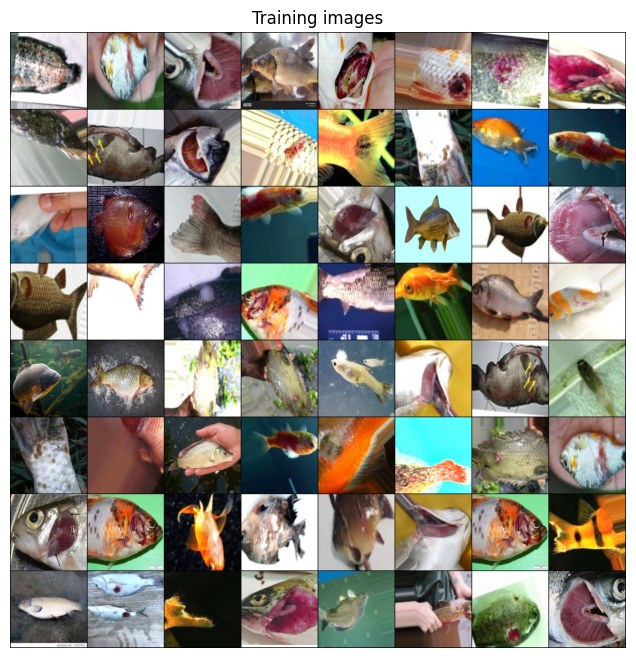

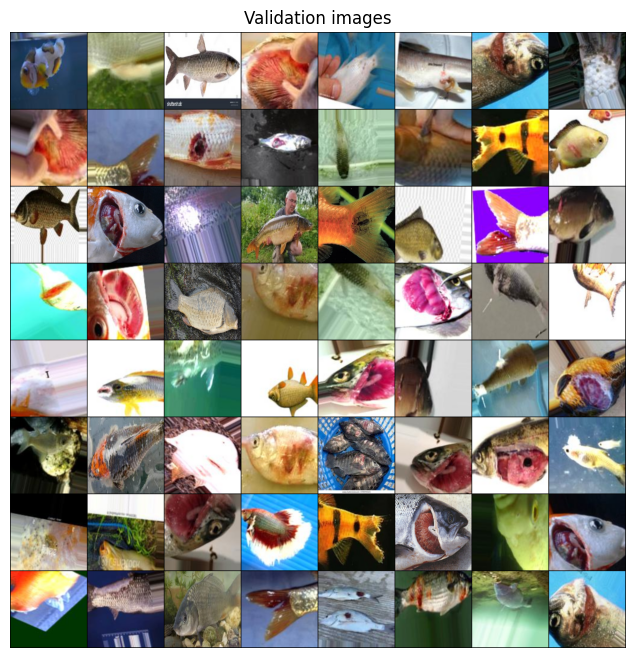

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


print(get_model_list())

dm = FishDiseaseDataModule(height_width=(224, 224), batch_size=64, num_workers=0)
dm.prepare_data()
dm.setup()

for batch, (images, labels) in enumerate(dm.val_dataloader()):  
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        images[:64], 
        padding=2,
        normalize=True),
        (1, 2, 0)))
    plt.show()
    # print(f"Batch {batch}: len(images) = {len(images)}, len(labels) = {len(labels)}")
    break


for batch, (images, labels) in enumerate(dm.train_dataloader()):  
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Validation images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        images[:64], 
        padding=2,
        normalize=True),
        (1, 2, 0)))
    plt.show()
    # print(f"Batch {batch}: len(images) = {len(images)}, len(labels) = {len(labels)}")
    break

## 4) Training model

training model fish-disease-resnet18-baseline


Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.7 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


training model fish-disease-resnet18-augmented


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.7 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


training model fish-disease-resnet34-baseline


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 21.8 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
21.8 M    Trainable params
0         Non-trainable params
21.8 M    Total params
87.191    Total estimated model params size (MB)
119       Modules in train mode
0         Modules in eval mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


training model fish-disease-resnet34-augmented


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 21.8 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
21.8 M    Trainable params
0         Non-trainable params
21.8 M    Total params
87.191    Total estimated model params size (MB)
119       Modules in train mode
0         Modules in eval mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


training model fish-disease-resnet50-baseline


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 25.6 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.228   Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


training model fish-disease-resnet50-augmented


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 25.6 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.228   Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


training model fish-disease-resnet101-baseline


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 44.5 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
44.5 M    Trainable params
0         Non-trainable params
44.5 M    Total params
178.197   Total estimated model params size (MB)
290       Modules in train mode
0         Modules in eval mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


training model fish-disease-resnet101-augmented


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 44.5 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
44.5 M    Trainable params
0         Non-trainable params
44.5 M    Total params
178.197   Total estimated model params size (MB)
290       Modules in train mode
0         Modules in eval mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


training model fish-disease-resnet152-baseline


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 60.2 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
60.2 M    Trainable params
0         Non-trainable params
60.2 M    Total params
240.771   Total estimated model params size (MB)
426       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


training model fish-disease-resnet152-augmented


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 60.2 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
60.2 M    Trainable params
0         Non-trainable params
60.2 M    Total params
240.771   Total estimated model params size (MB)
426       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


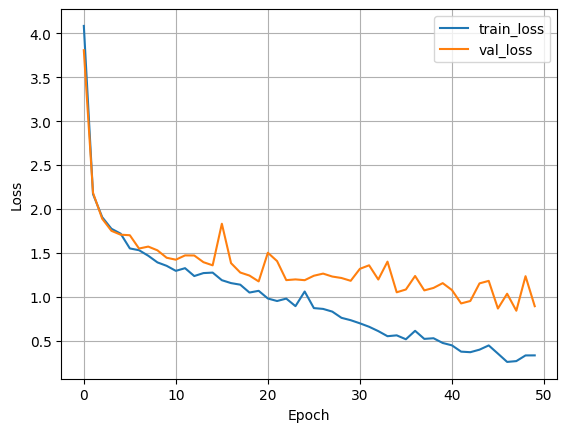

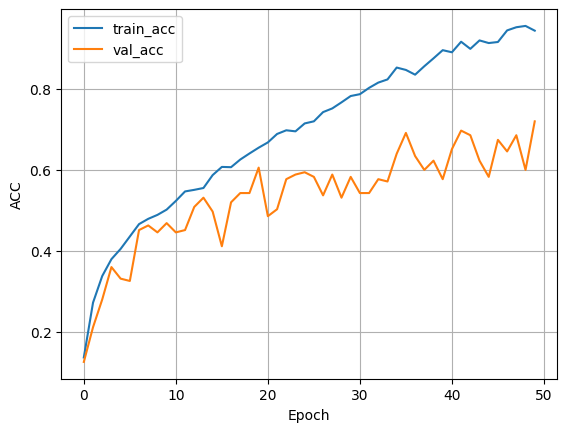

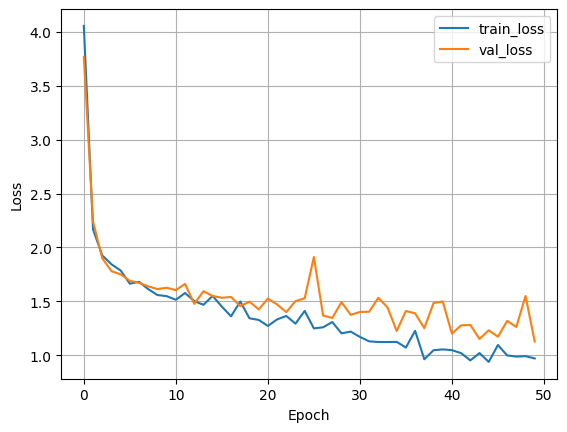

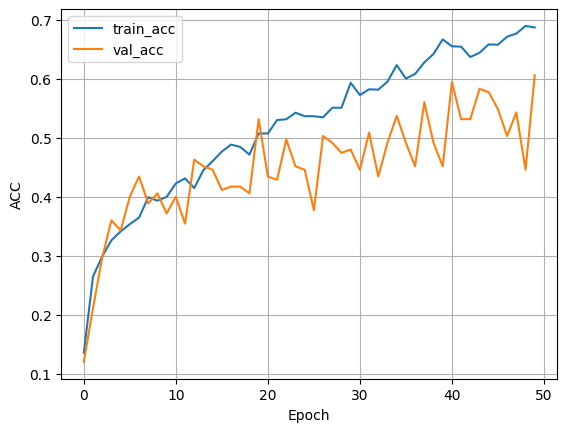

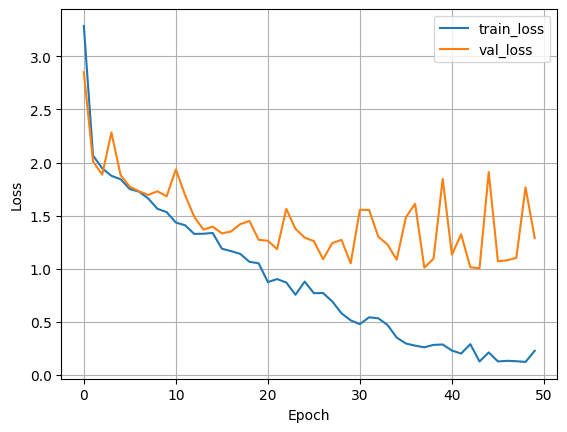

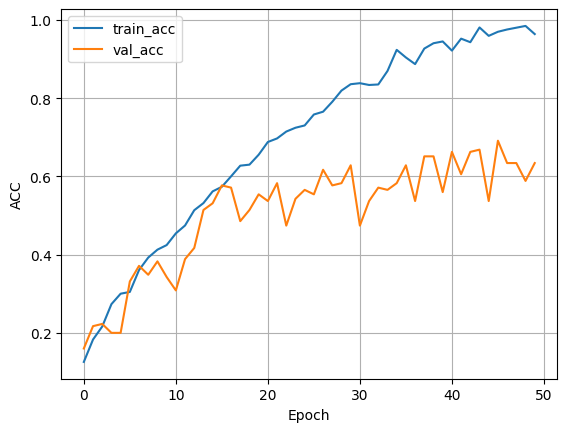

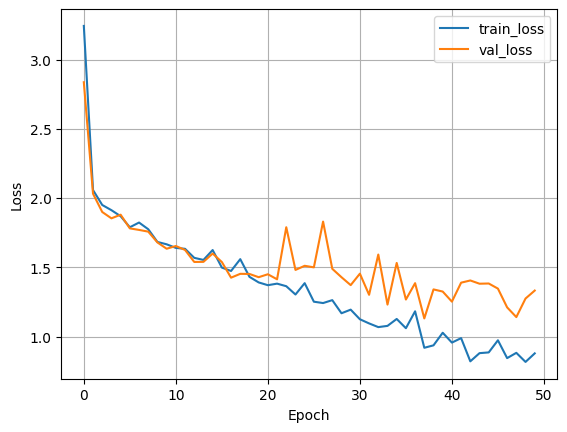

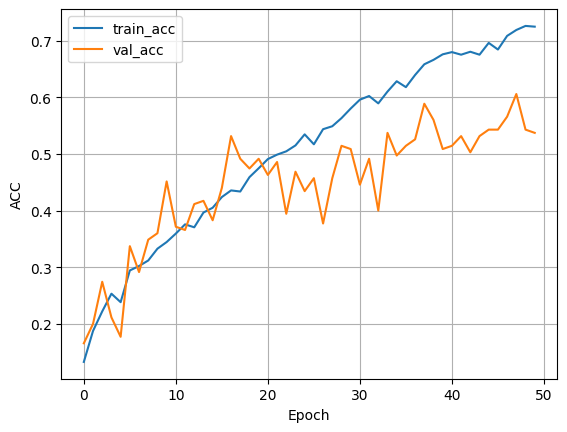

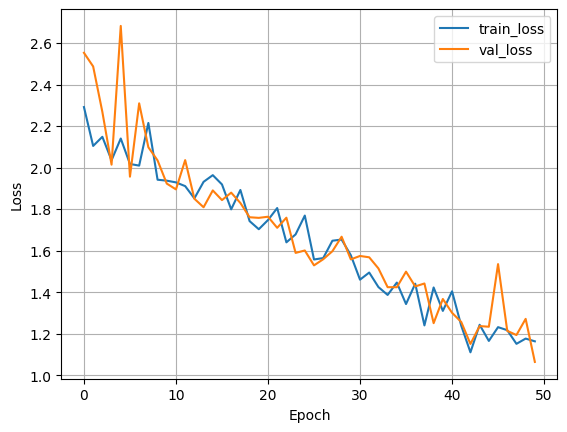

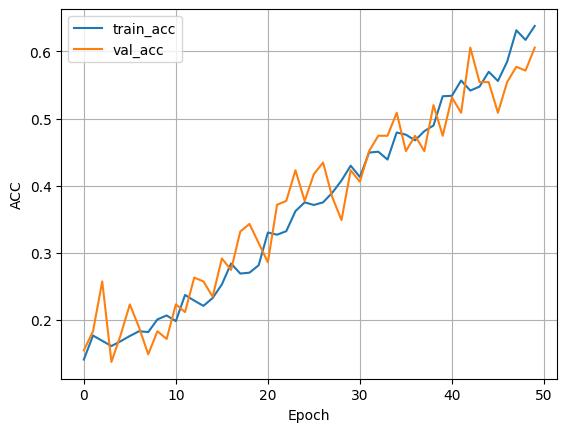

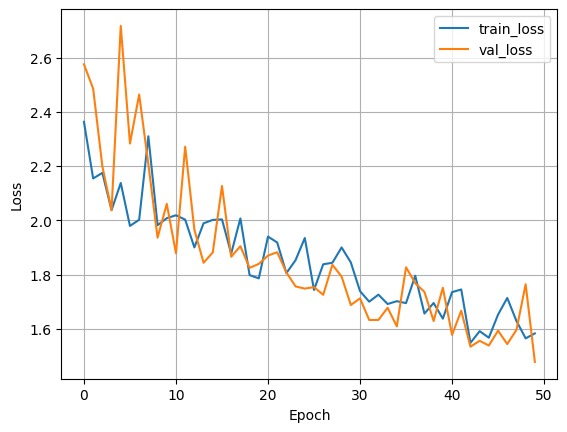

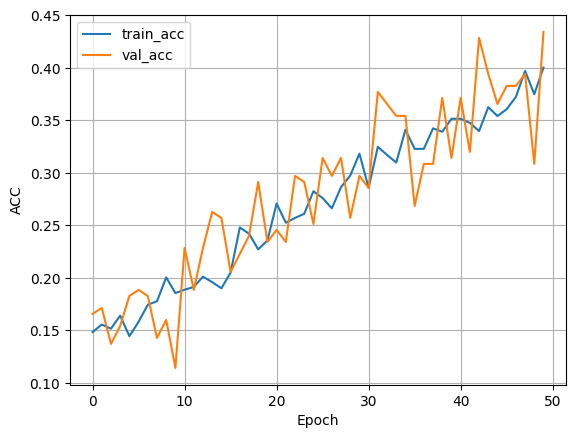

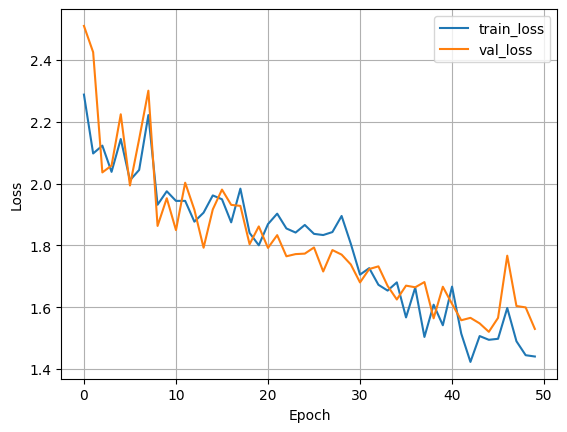

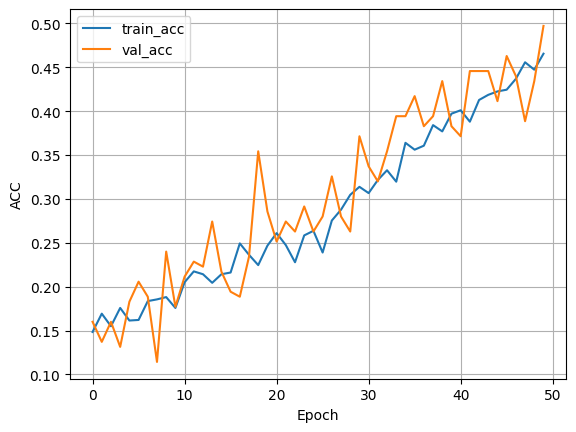

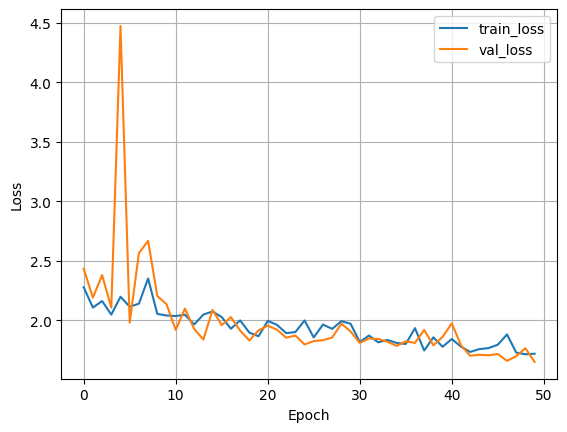

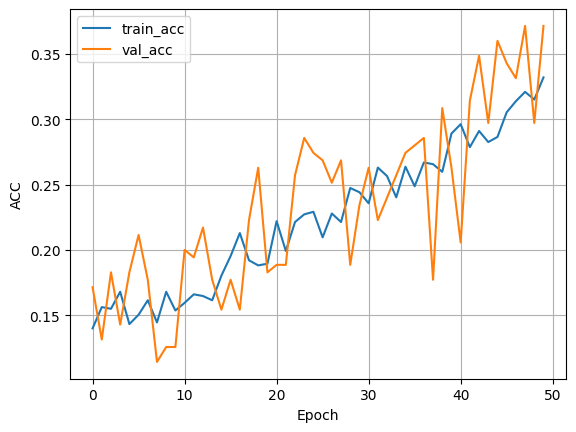

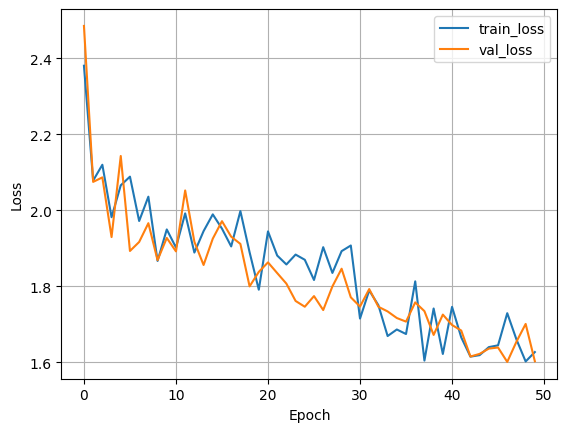

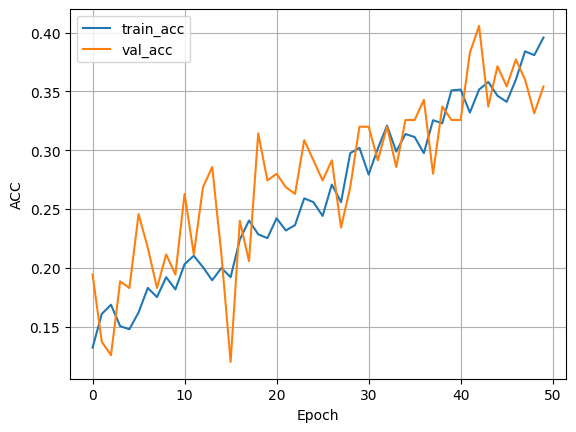

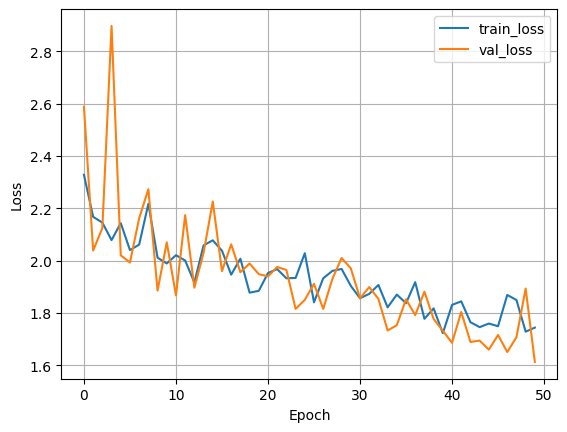

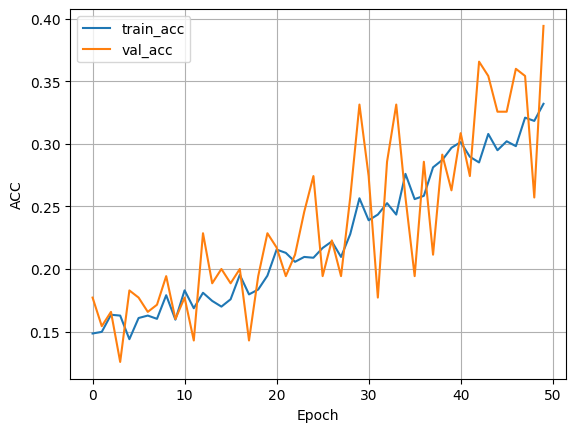

In [4]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
import torch
import torchvision
from lightning.pytorch.callbacks import ModelCheckpoint

def train_model(resnet_type, augmentation):
    model_name = f"fish-disease-{resnet_type}-{augmentation}"
    print(f"training model {model_name}")

    if augmentation == "augmented":
        augment_data = True
    else:
        augment_data = False   

    dm = FishDiseaseDataModule(height_width=(224, 224), batch_size=64, num_workers=4, augment_data=augment_data)
   
    pytorch_model = torch.hub.load('pytorch/vision', resnet_type, weights=None)
    L.pytorch.seed_everything(123)
    print(pytorch_model)

    lightning_model = LightningModel(model=pytorch_model, learning_rate=0.005)

    # Set up the checkpoint callback to save the model every 10 epochs
    checkpoint_callback = ModelCheckpoint(
        dirpath=f"checkpoints/{model_name}/",
        filename="{epoch}-{val_loss:.2f}",
        save_top_k=-1,  # Save all checkpoints based on the interval
        save_weights_only=True,  # Save only the model weights
        every_n_epochs=10,  # Save after every 10 epochs
    )   

    trainer = L.Trainer(
        max_epochs=50,
        accelerator="auto",
        devices="auto",
        logger=CSVLogger(save_dir="logs/", name=model_name),
        deterministic=True,
        callbacks=[checkpoint_callback],
        log_every_n_steps=8,  # Log after every 8 batch
    )

    trainer.fit(model=lightning_model, datamodule=dm)
    torch.save(pytorch_model.state_dict(), f"{model_name}.pt") # lưu model cuối cùng sau khi chạy hết epochs
    plot_csv_logger(f"{trainer.logger.log_dir}/metrics.csv", model_name=model_name)

def test_model(resnet_type, augmentation):
    model_name = f"fish-disease-{resnet_type}-{augmentation}"
    print(f"testing model {model_name}")

    augment_data = augmentation == "augmented"
    dm = FishDiseaseDataModule(height_width=(224, 224), batch_size=64, num_workers=4, augment_data=augment_data)

    pytorch_model = torch.hub.load('pytorch/vision', resnet_type, weights=None)
    pytorch_model.load_state_dict(torch.load(f"{model_name}.pt"))  # Load the trained model weights
    pytorch_model.eval()  # Set the model to evaluation mode

    lightning_model = LightningModel(model=pytorch_model, learning_rate=0.005)

    trainer = L.Trainer(
        accelerator="auto",
        devices="auto",
        logger=CSVLogger(save_dir="logs/", name=f"test-{model_name}"),
    )

    results = trainer.test(model=lightning_model, datamodule=dm)
    print(f"Test results for {model_name}: {results}")
    plot_csv_logger(f"{trainer.logger.log_dir}/metrics.csv", model_name=f"test-{model_name}")


def train_models(model_list):
    for model in model_list:
        train_model(model, "baseline")
        train_model(model, "augmented")

def test_models(model_list):
    for model in model_list:
        test_model(model, "baseline")
        test_model(model, "augmented")

if __name__ == "__main__":
    model_list = get_model_list()
    train_models(model_list) 

## 5) Evaluate 

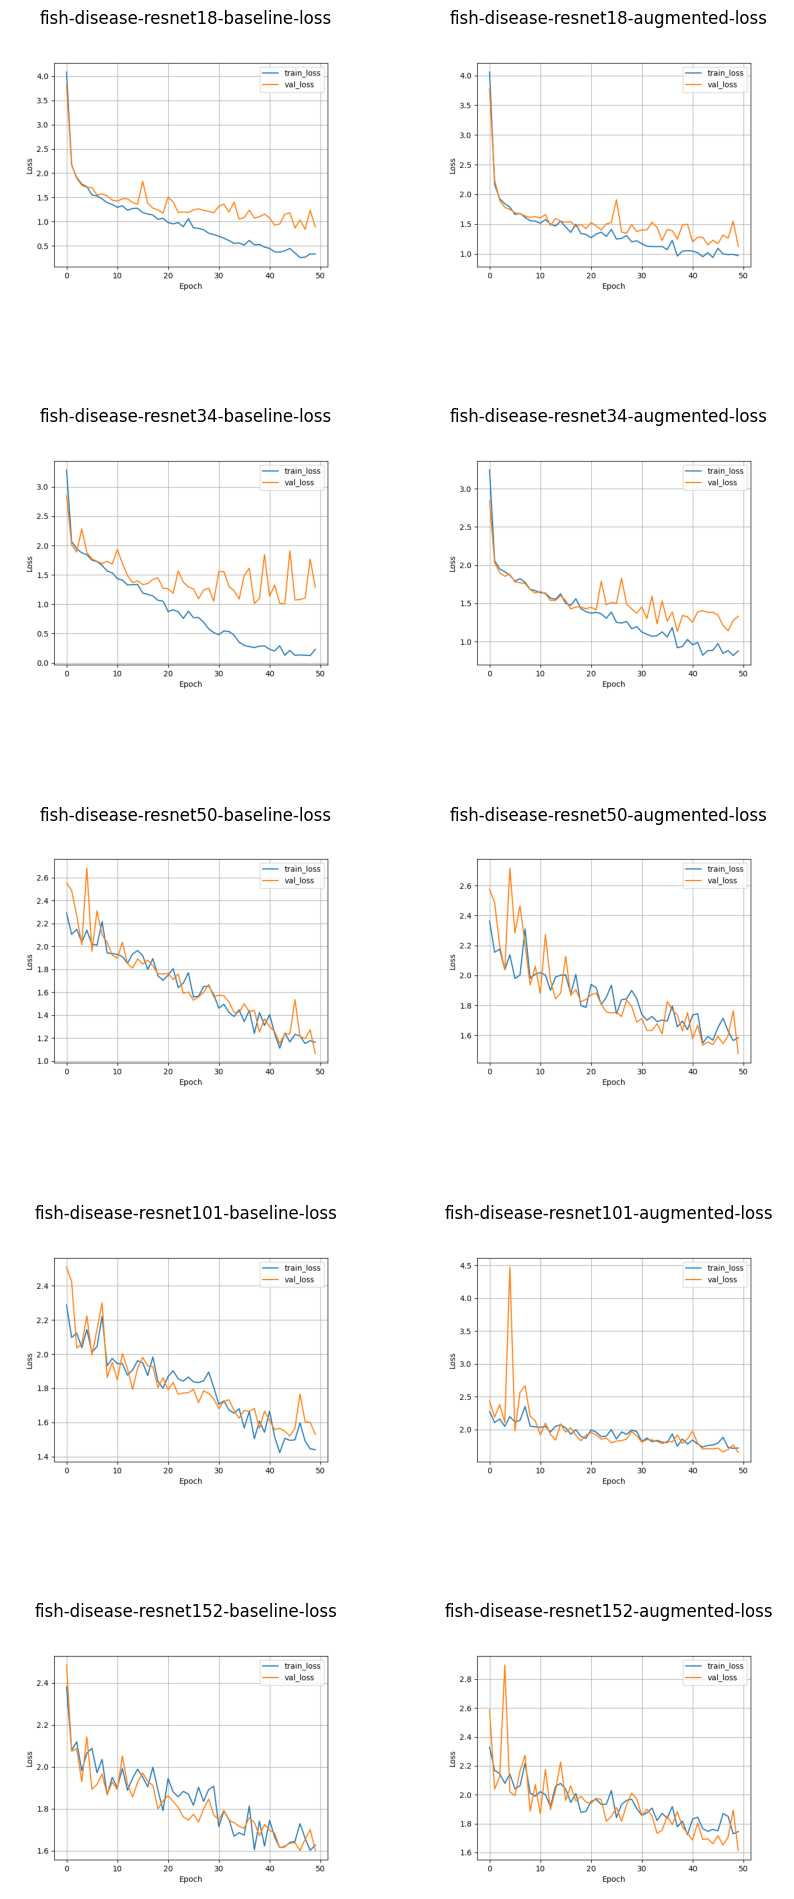

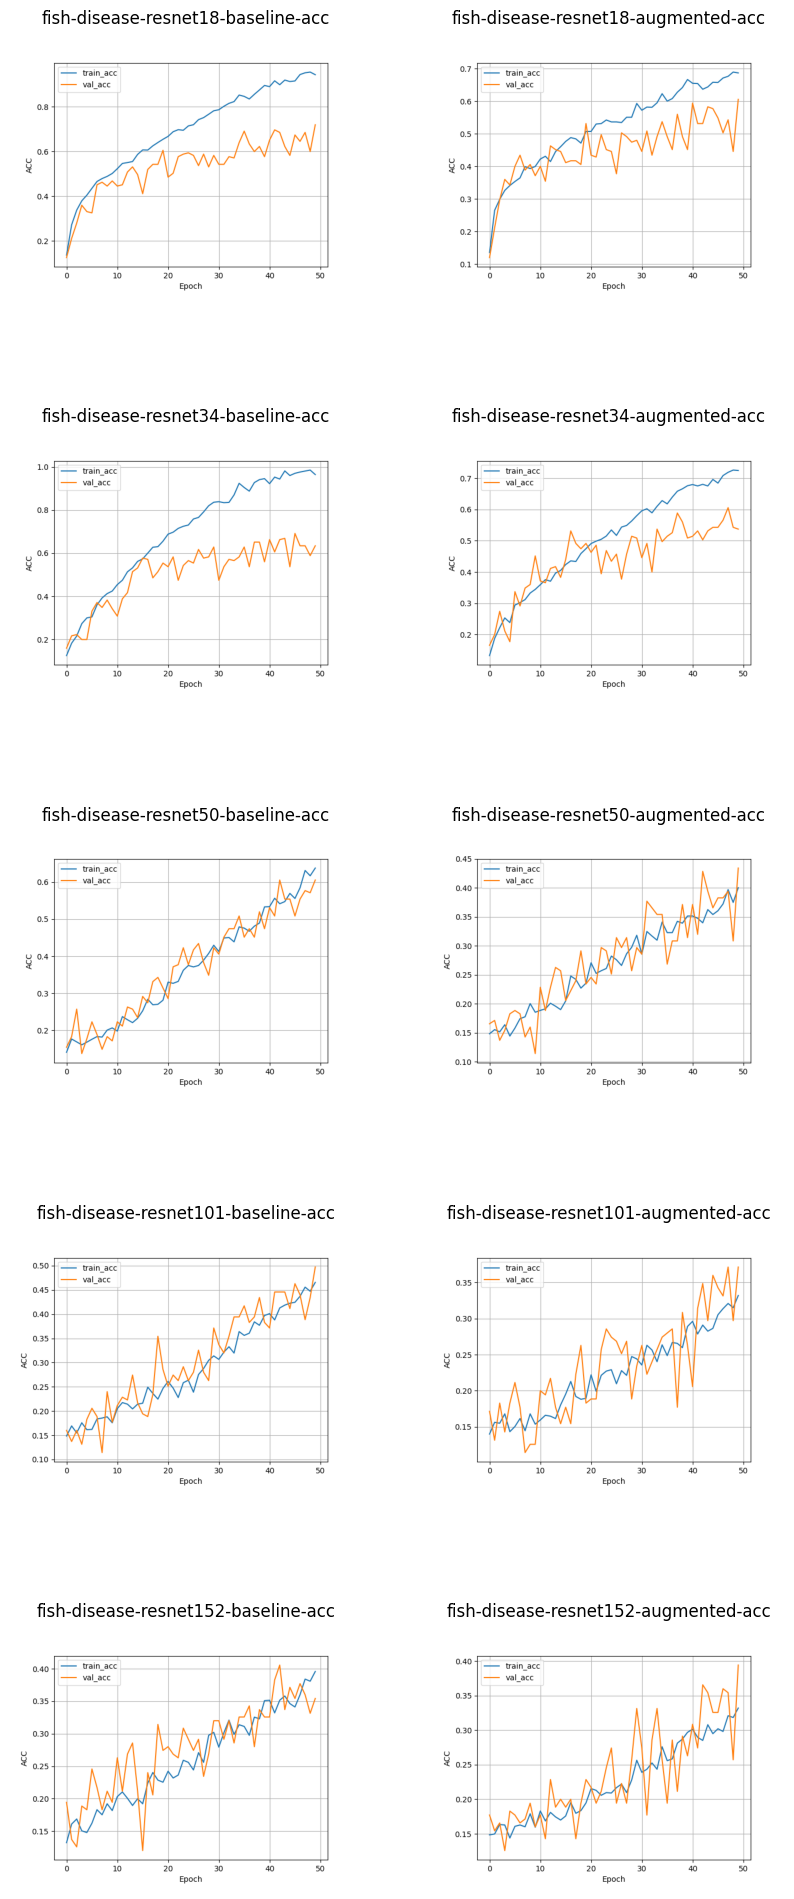

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

for metric_type in ['loss', 'acc']:
    model_list = get_model_list()
    num_rows = len(model_list)
    num_cols = 2

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
    plt.title(f"Training and validation {metric_type}")
    plt.axis("off")

    for row, resnet_type in enumerate(model_list):
        for col, augmentation in enumerate(['baseline', 'augmented']):
                title = f"fish-disease-{resnet_type}-{augmentation}-{metric_type}"
                img = Image.open(f"{title}.png")
                axs[row, col].imshow(img)
                axs[row, col].set_title(title)
                axs[row, col].axis("off")
    plt.show()

In [6]:
import lightning as L
import torch
from lightning.pytorch.loggers import CSVLogger

def test_model(resnet_type, augmentation):
    model_name = f"fish-disease-{resnet_type}-{augmentation}"
    print(f"testing model {model_name}")

    if augmentation == "augmented":
        augment_data = True
    else:
        augment_data = False   

    dm = FishDiseaseDataModule(height_width=(224, 224), batch_size=64, num_workers=4, augment_data=augment_data)
   
    pytorch_model = torch.hub.load('pytorch/vision', resnet_type, weights=None)
    pytorch_model.load_state_dict(torch.load(f"{model_name}.pt"))

    L.pytorch.seed_everything(123)

    lightning_model = LightningModel(model=pytorch_model, learning_rate=0.005)

    trainer = L.Trainer(
        max_epochs=50,
        accelerator="auto",
        devices="auto",
        logger=CSVLogger(save_dir="logs/", name=model_name),
        deterministic=True,
    )

    trainer.test(model=lightning_model, datamodule=dm)

model_list = get_model_list()
for model in model_list:
    test_model(model, "baseline")
    test_model(model, "augmented")

testing model fish-disease-resnet18-baseline


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/tmp/ipykernel_22/4020639932.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pytorch_model.load_state_di

Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9285714030265808     │
└───────────────────────────┴───────────────────────────┘

testing model fish-disease-resnet18-augmented


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7200000286102295     │
└───────────────────────────┴───────────────────────────┘

testing model fish-disease-resnet34-baseline


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8871428370475769     │
└───────────────────────────┴───────────────────────────┘

testing model fish-disease-resnet34-augmented


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.758571445941925     │
└───────────────────────────┴───────────────────────────┘

testing model fish-disease-resnet50-baseline


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.677142858505249     │
└───────────────────────────┴───────────────────────────┘

testing model fish-disease-resnet50-augmented


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4714285731315613     │
└───────────────────────────┴───────────────────────────┘

testing model fish-disease-resnet101-baseline


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            0.5            │
└───────────────────────────┴───────────────────────────┘

testing model fish-disease-resnet101-augmented


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.32428571581840515    │
└───────────────────────────┴───────────────────────────┘

testing model fish-disease-resnet152-baseline


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3985714316368103     │
└───────────────────────────┴───────────────────────────┘

testing model fish-disease-resnet152-augmented


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}
Label_index:  {'Parasitic diseases': 0, 'Bacterial gill disease': 1, 'Bacterial Red disease': 2, 'Fungal diseases Saprolegniasis': 3, 'Healthy Fish': 4, 'Viral diseases White tail disease': 5, 'Bacterial diseases - Aeromoniasis': 6}


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.37714284658432007    │
└───────────────────────────┴───────────────────────────┘